<a href="https://colab.research.google.com/github/cabamarcos/P1-RRNN/blob/main/P1_RRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

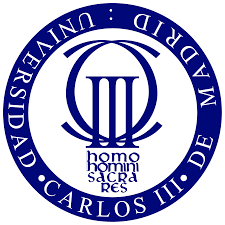

# PRÁCTICA 1: REDES DE NEURONAS
Autores: Pablo Hidalgo Delgado y Marcos Caballero Cortés   

NIAs: 100451225 y 100451247


# PREGUNTAS PROFE


1.   El error de test, con los datos normalizados y desnormalizados??? si es con desnormalizados, el error de entrenamiento y de validación no va a estar en la misma escala.

2.   Código de la RELU, la neurona de salida es activacion sigmoide?? segun lo que nos diste si

3. Exactamente, el error de entrenamiento y validacion que es?? se nos pide guardar la evolucion. Vale para el error de entrenamiento ya que lo calculamos al entrenar el adaline dentro del propio modelo pero para el de validacion?? lo que hacemos es predecir con X_validation y luego calcular el error con y_validation--> solo nos sale un valor, no hay evolucion!



## 1. Introducción
El propósito de esta práctica es abordar un problema real de regresión utilizando dos modelos de redes de neuronas supervisados:

*   El modelo lineal Adaline.
*   El modelo no-lineal Perceptrón Multicapa.

Para ello, se nos dispone de un conjunto de datos relacionados con medidas realizadas en una turbina de gas a lo largo de 4 años. Debemos predecir el rendimiento energético de la turbina, mostrado en el campo TEY, haciendo uso del resto de mediciones de sensores.




## 2. Leer los conjuntos de datos


En primer lugar, importamos todas las librerías que se van a utilizar a lo largo de la práctica

In [1]:
import random
import time

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model


import pickle
import seaborn as sns
import json

Leemos los conjuntos de datos, correspondientes a las medidas de 1 solo año, y los juntamos en un mismo dataframe de pandas.

In [2]:
archivos_csv = ['gt_2011.csv', 'gt_2012.csv', 'gt_2013.csv', 'gt_2014.csv', 'gt_2015.csv']

datos = pd.DataFrame()

# Concatenamos todos los archivos en un mismo dataframe
for archivo in archivos_csv:
    # Leemos el archivo
    df_temporal = pd.read_csv(archivo)
    # Concatenamos el archivo en el dataframe final
    datos = pd.concat([datos, df_temporal], ignore_index=True)

## 3. Análisis Exploratorio de Datos (EDA)
Antes de empezar con la división en datos de entrenamiento y test, vamos a realizar un pequeño análisis exploratorio de datos (EDA). De esta manera, podremos investigar y resumir las características más importantes de nuestro dataset. Esto nos servirá para comprender mejor los datos y optimizar la obtención de nuestro modelo.


### 3.1 Información básica

In [3]:
datos.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36733 entries, 0 to 36732
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      36733 non-null  float64
 1   AP      36733 non-null  float64
 2   AH      36733 non-null  float64
 3   AFDP    36733 non-null  float64
 4   GTEP    36733 non-null  float64
 5   TIT     36733 non-null  float64
 6   TAT     36733 non-null  float64
 7   TEY     36733 non-null  float64
 8   CDP     36733 non-null  float64
 9   CO      36733 non-null  float64
 10  NOX     36733 non-null  float64
dtypes: float64(11)
memory usage: 3.1 MB


El conjunto de datos se compone de 36733 instancias y 11 atributos de tipo float64.

También podemos observar que no existen columnas que contengan valores nulos.

### 3.2 Atributos compuestos de valores constantes

A continuación, vamos a analizar si existen columnas constantes en nuestro conjunto de datos. En ese caso, podremos eliminarlas de nuestro dataset ya que no aportan ninguna información a la variable de respuesta y no existe riesgo de information leakage.

In [4]:
# Eliminamos las columnas con solo un valor único
columnas_constantes = []
for col in datos.columns:
    if datos[col].nunique() == 1:
        print(col)
        columnas_constantes.append(col)
if len(columnas_constantes) == 0:
  print("No existen atributos con valores constantes")

No existen atributos con valores constantes


## 4. División de datos en train, validation y test.
Una vez explorado y analizado nuestro conjunto de datos, dividimos el dataset en conjuntos de entrenamiento (train), prueba (test) y validación (validation). Para ello, utilizamos la función train_test_split de la librería sklearn. Dividimos los datos en un 70% para train, un 15% para test, y un 15% para validation tal y como se nos pide en el enunciado de la práctica.

Antes de realizar la división, debemos separar la variable de respuesta del resto del conjunto de datos.

In [5]:
X = datos.drop("TEY", axis = 1)
y = datos["TEY"]
y

0        134.67
1        134.67
2        135.10
3        135.03
4        134.67
          ...  
36728    109.08
36729    108.79
36730    107.81
36731    131.41
36732    125.41
Name: TEY, Length: 36733, dtype: float64

Dividimos el conjunto de datos. Lo hacemos especificando el parámetro random_state a 42 para que se aleatorizen los datos y el resultado sea reproducible.


In [6]:
# Dividir los datos originales en conjuntos de entrenamiento (70%) y test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Dividir el conjunto de prueba en conjuntos de validación (15%) y test (15%)
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

X_validation

,AT,AP,AH,AFDP,GTEP,TIT,TAT,CDP,CO,NOX
9060,17.1960,995.96,83.276,4.1779,20.454,1057.9,549.36,10.587,3.0602,73.598
33780,29.7170,1010.30,57.389,4.4296,30.199,1099.9,544.72,13.204,0.9261,53.272
7555,13.1260,999.57,84.483,4.1593,24.254,1084.3,550.15,11.873,1.6692,74.223
36051,20.5170,1017.70,64.559,4.2873,30.931,1100.0,540.34,13.515,1.7370,51.516
8023,8.9965,1025.00,83.895,5.7124,32.828,1100.1,529.53,13.879,0.4909,63.462
...,...,...,...,...,...,...,...,...,...,...
27760,17.4740,1019.90,89.325,3.9248,22.169,1065.0,550.01,11.197,3.1294,61.156
13160,23.6420,1013.50,83.250,4.4636,25.764,1092.3,550.01,12.127,1.5099,64.478
15718,4.8652,1013.60,91.351,2.9773,23.396,1081.9,550.03,11.720,1.6524,83.076
10968,29.9860,1009.30,57.941,4.2750,26.176,1092.9,549.64,12.216,1.5581,62.199


## 5. Preproceso
Previamente a entrenar los modelos, debemos realizar una transformación de los datos para que puedan ser interpretados por el algoritmo de manera eficiente. Las transformaciones de datos que realizamos son las siguientes:

### 5.1 Normalización
Para que no se produzca information leakage y no dar información al cinjunto de test, normalizamos todos los datos con el mínimo y máximo obtenido del conjunto de entrenamiento.

In [7]:
for columna in X_train:
  # Obtenemos el minimo y el maximo de cada columna del conjunto de train
  min = X_train[columna].min()
  max = X_train[columna].max()
  # Conjunto de entrenamiento
  X_train[columna] = (X_train[columna] - min)/(max - min)
  # Conjunto de validación
  X_validation[columna] = (X_validation[columna] - min)/(max - min)
  # Conjunto de test
  X_test[columna] = (X_test[columna] - min)/(max - min)

y_min = y_train.min()
y_max = y_train.max()
# Conjunto de entrenamiento
y_train = (y_train - y_min)/(y_max - y_min)
# Conjunto de validación
y_validation = (y_validation - y_min)/(y_max - y_min)
# Conjunto de test
y_test = (y_test - y_min)/(y_max - y_min)


y_test

33895    0.606320
25272    0.664233
15758    0.427924
26083    0.362961
23653    0.447690
           ...   
28341    0.391540
28266    0.365983
11243    0.134962
3787     0.399471
7667     0.445424
Name: TEY, Length: 5510, dtype: float64

### 5.2 Aleatorización
La aleatorización de los datos la hemos realizado al dividir el conjunto de datos en train, test y validation al especificar el parametro shuffle = True

## 6. Modelo lineal Adaline

### 6.1 Adaline implementado con nested loops (ineficiente)

In [8]:
class Adaline_for:
    def __init__(self, learning_rate=0.1, epochs=50, random_seed = 45):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.random_seed = random_seed
        self.error_entrenamiento = []
        self.historical_weights = []

    def fit(self, X, y):
      # Inicializamos el Adaline
        self.__initialize_Adaline(X)

        # Para cada época
        for i in range(self.epochs):
          error_filas = []
          # Para cada fila
          for fila in range(X.shape[0]):
            # Calculamos la salida
            salida = self.weights * X.loc[fila]
            salida = salida.sum() + self.bias
            # Obtenemos el error
            error = y.loc[fila] - salida
            error_filas.append(error**2) # Insertamos el error al cuadrado de cada fila para luego obtener el MSE de entrenamiento
            # Actualizamos los pesos
            self.weights += self.learning_rate * error * X.loc[fila]
            # Actualizamos el umbral
            self.bias += self.learning_rate * error
          # Obtenemos el MSE y lo insertamos en la lista del error de entrenamiento
          self.error_entrenamiento.append(np.array(error_filas).mean())

    def predict(self, X):
      # Calculamos la salida para cada muestra en X
      predictions = []
      for fila in range(X.shape[0]):
          salida = self.weights.dot(X.loc[fila]) + self.bias
          predictions.append(salida)  # Agrega la salida a la lista de predicciones
      return predictions


    def __initialize_Adaline(self,X):
        np.random.seed(self.random_seed)
        n_samples, n_features = X.shape
        self.weights = np.random.uniform(-1,1,size = n_features)
        self.bias = np.random.uniform(-1,1)

Para comprobar y analizar su funcionamiento, utilizamos los datos artificiales de aula global.

[0.023532327160505413, 1.903334288724916e-07, 7.368503256367195e-12, 2.8296287394313035e-16, 1.0863360768177715e-20, 4.172781915938806e-25, 2.3094295119681798e-29, 6.996682391201212e-30, 6.953874361141329e-30, 6.964597939071677e-30]
Tiempo de entrenamiento:  12.427478313446045


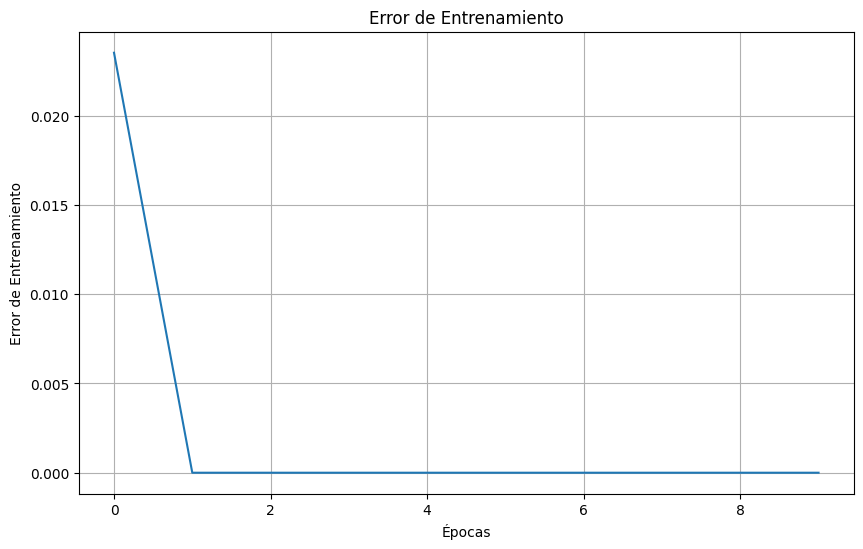

In [9]:
epocas = 10
learning_rate = 0.1
# Leemos el conjunto de datos de aulaglobal
datos_prueba = pd.read_csv("datosArtificiales.txt", delimiter=' ', header=None)
# Dividimos los datos en atributos (X) y salida (y)
X_prueba = datos_prueba.iloc[:,:2]
y_prueba = datos_prueba.iloc[:,-1]
# Entrenamos el modelo
modelo_prueba_for = Adaline_for(learning_rate = learning_rate, epochs=epocas)
start_time = time.time()
modelo_prueba_for.fit(X_prueba,y_prueba)
tiempo_total = time.time() - start_time
print(modelo_prueba_for.error_entrenamiento)
print("Tiempo de entrenamiento: ", tiempo_total)

# Error de entrenamiento
error_entrenamiento = modelo_prueba_for.error_entrenamiento

# Número de épocas
epocas = list(range(1, len(error_entrenamiento) + 1))

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(error_entrenamiento)
plt.title('Error de Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Error de Entrenamiento')
plt.grid(True)
plt.show()

Observamos que el tiempo de entrenamiento es extremadamente alto para ser un modelo simple y tener únicamente 50 épocas.

Por tanto, decidimos implementar el modelo Adaline de una forma más eficiente. Para ello, utilizamos matrices (numpy arrays) en vez de utilizar un nested loop (complejidad exponencial).

### 6.2 Adaline implementado con matrices (eficiente)



In [10]:
class Adaline:
    def __init__(self, learning_rate=0.1, epochs=100, random_seed = 45):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.umbral = None
        self.random_seed = random_seed
        self.error_entrenamiento = []

    def __initialize_Adaline(self,X):
        np.random.seed(self.random_seed)
        n_samples, n_features = X.shape
        self.weights = np.random.uniform(-1, 1, size=(n_features, 1))
        self.umbral = np.random.uniform(-1,1)

    def fit(self, X, y):
        # Inicializamos el Adaline
        self.__initialize_Adaline(X)
        # Convertimos X e y a dos arrays de numpy
        X = X.values
        y = y.to_numpy().reshape(-1, 1)

        for i in range(self.epochs):
          # Obtenemos la salida
          salida = np.dot(X, self.weights) + self.umbral

          # Obtenemos los errores
          errores = y - salida

          # Actualizamos el vector de pesos
          new_weights = self.learning_rate * X * errores # Calculamos los nuevos pesos para cada entrada
          media_new_weights = np.mean(new_weights, axis=0) # Calculamos la media de los nuevos pesos
          self.weights += media_new_weights.reshape(-1, 1)

          # Actualizamos el umbral
          self.umbral += self.learning_rate * errores.mean()

          # Obtenemos y guardamos el MSE
          error_entrenamiento = mean_squared_error(salida, y)
          self.error_entrenamiento.append(error_entrenamiento)

    def predict(self, X):
      # Convertimos X a un array de numpy
      X = X.values
      salida = np.dot(X, self.weights) + self.umbral
      return salida



A continuación, comprobamos nuestra implementación del Adaline utilizando los datos artificiales proporcionados en aulaglobal. Para ello, entrenaremos varios modelos con diferentes tasas de aprendizaje y analizaremos el error de entrenamiento.

Evolución del error de entrenamiento para learning_rate 0.8 = [2.158244878581515, 0.28414215584736857, 0.18058598678638343, 0.15573155829155408, 0.1368033127400094, 0.12035943738142933, 0.10596763935799346, 0.09336136539818929, 0.08231327249439994, 0.0726256141723569, 0.06412618221633133, 0.05666496551607798, 0.050111255731325015, 0.04435113331555994, 0.03928528342232312, 0.034827098198229337, 0.030901027729016328, 0.027441146891559288, 0.02438990969081674, 0.021697066414137937, 0.019318722192147905, 0.017216518381333545, 0.015356920635561022, 0.013710599661569884, 0.012251892499961642, 0.010958333775584056, 0.00981024775182525, 0.008790393230207718, 0.007883654384131711, 0.007076771524756893, 0.006358106586132969, 0.005717438801671627, 0.005145786638667826, 0.004635252573778297, 0.0041788877405165206, 0.0037705738689211995, 0.003404920275402888, 0.0030771739541422738, 0.0027831410761778213, 0.002519118423577709, 0.0022818334782638682, 0.002068392051982347, 0.0018762324889243284, 0.001

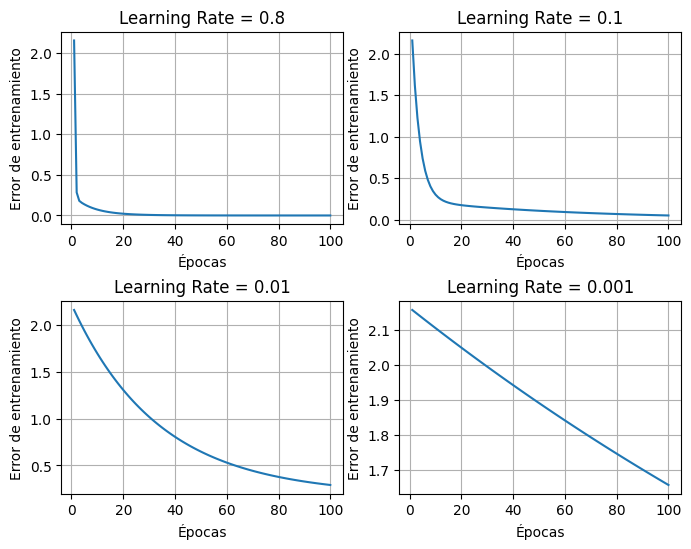

Tiempo de entrenamiento para learning rate 0.8 = 0.04684162139892578 segundos
Tiempo de entrenamiento para learning rate 0.1 = 0.04090118408203125 segundos
Tiempo de entrenamiento para learning rate 0.01 = 0.11171865463256836 segundos
Tiempo de entrenamiento para learning rate 0.001 = 0.07736730575561523 segundos


In [11]:
# Definimos las tasas de aprendizaje a probar
learning_rates = [0.8, 0.1, 0.01, 0.001]
epochs = 100

# Representación gráfica de la evolución del error de entrenamiento
fig, axs = plt.subplots(2, 2, figsize=(8, 6)) # Creamos un grid de 2x2 para las gráficas
fig.subplots_adjust(hspace=0.4)

tiempo_entrenamiento = []
for i, lr in enumerate(learning_rates):
    # Entrenamos el modelo con la tasa de aprendizaje actual
    modelo_prueba = Adaline(learning_rate=lr, epochs=epochs)
    start_time = time.time()
    modelo_prueba.fit(X_prueba, y_prueba)
    tiempo_total = time.time() - start_time
    tiempo_entrenamiento.append(tiempo_total)
    # Representamos gráficamente el error de entranamiento de cada modelo con diferente tasa de aprendizaje
    ax = axs[i // 2, i % 2]
    ax.plot(range(1, len(modelo_prueba.error_entrenamiento) + 1), modelo_prueba.error_entrenamiento)
    ax.set_title(f'Learning Rate = {lr}')
    ax.set_xlabel('Épocas')
    ax.set_ylabel('Error de entrenamiento')
    ax.grid()

    print(f"Evolución del error de entrenamiento para learning_rate {lr} = {modelo_prueba.error_entrenamiento}")

plt.show()

# Imprimimos los tiempos de entrenamiento correspondientes a cada tasa de aprendizaje
for lr, tiempo in zip(learning_rates, tiempo_entrenamiento):
    print(f"Tiempo de entrenamiento para learning rate {lr} = {tiempo} segundos")

Podemos observar que el error cuadrático medio desciende en cada época, y se va aproximando a 0, por lo que el modelo está correctamente implementado.

### 6.3. Elección del mejor modelo
A continuación, debemos elegir los mejores hiperparámetros. Para ello, construimos distintos modelos con diferentes hiperparámetros y lo evaluamos con el conjunto de validación. Escogeremos el modelo con la combinación de hiperparámetros cuyo MSE sea el menor.

(LR=0.3, Épocas=10) --> Tiempo de entrenamiento 0.04 s , MSE validación: 7.10e-02, MSE entrenamiento: [0.7531999341592132, 0.1416705964672538, 0.10194724804624258, 0.0952944747987868, 0.09081177744436571, 0.08670922020797173, 0.08286680992825711, 0.07926150236996071, 0.07587694990247766, 0.07269824642306744]
(LR=0.3, Épocas=50) --> Tiempo de entrenamiento 0.15 s , MSE validación: 2.37e-02, MSE entrenamiento: [0.7531999341592132, 0.1416705964672538, 0.10194724804624258, 0.0952944747987868, 0.09081177744436571, 0.08670922020797173, 0.08286680992825711, 0.07926150236996071, 0.07587694990247766, 0.07269824642306744, 0.06971155025421956, 0.06690399214115567, 0.06426360468598531, 0.061779257734851316, 0.059440598487081095, 0.05723799593735422, 0.0551624893333587, 0.0532057403570141, 0.05135998875874724, 0.04961801119401836, 0.04797308302956309, 0.04641894290375001, 0.044949759841153535, 0.04356010273599573, 0.04224491203260508, 0.04099947344354915, 0.03981939355769565, 0.03870057720120868, 0

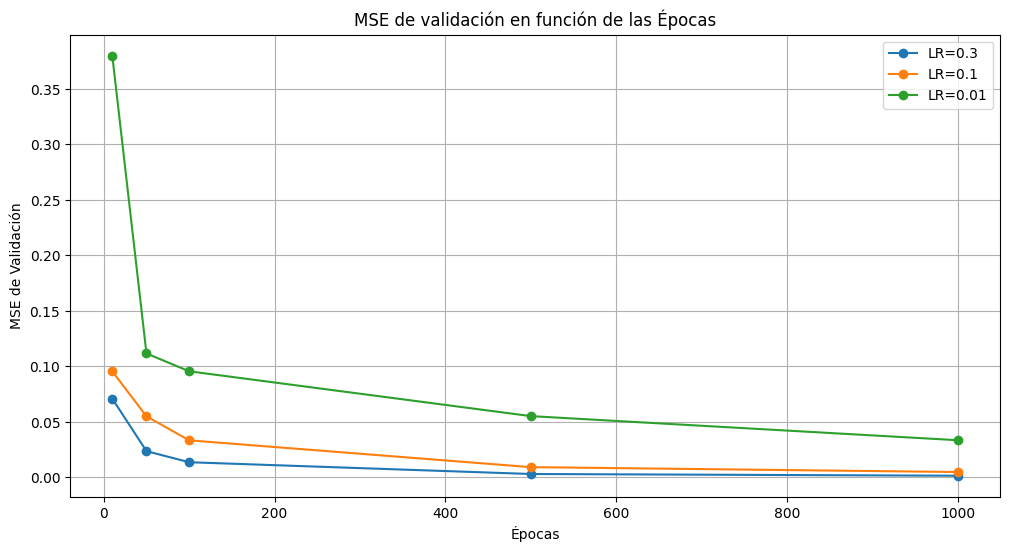

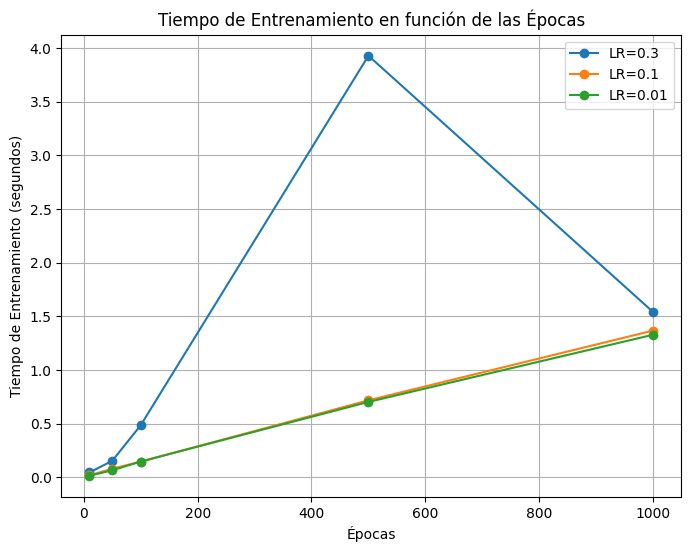

In [12]:
# Lista de tasas de aprendizaje a probar
learning_rates = [0.3, 0.1, 0.01]
# Lista de epochs a probar
epochs_values = [10, 50, 100, 500, 1000]

# Lista para almacenar los errores MSE de validación
mse_validation_values = []
tiempo_entrenamiento = []

for lr in learning_rates:
    mse_lr_values = []  # Almacenamos los errores para cada tasa de aprendizaje
    tiempo_lr_values = []  # Almacenamos los tiempos para cada tasa de aprendizaje

    for epochs in epochs_values:
        # Creamos el modelo
        modelo = Adaline(learning_rate=lr, epochs=epochs)
        # Entrenamos el modelo y obtenemos el tiempo que ha tardado en entrenarse
        start_time = time.time()
        modelo.fit(X_train, y_train)
        tiempo_total = time.time() - start_time
        tiempo_lr_values.append(tiempo_total) # Guardamos el tiempo
        # Realizamos la prediccion sobre el conjunto de validación
        prediccion = modelo.predict(X_validation)
        # Obtenemos el MSE y lo guardamos
        mse_validation = mean_squared_error(y_validation, prediccion)
        mse_lr_values.append(mse_validation)
        print(f'(LR={lr}, Épocas={epochs}) --> Tiempo de entrenamiento {tiempo_total:.2f} s , MSE validación: {mse_validation:.2e}, MSE entrenamiento: {modelo.error_entrenamiento}')
    print("\n")
    mse_validation_values.append(mse_lr_values)
    tiempo_entrenamiento.append(tiempo_lr_values)

# Creamos gráfica para diferentes tasas de aprendizaje
plt.figure(figsize=(12, 6))

for i, lr in enumerate(learning_rates):
    plt.plot(epochs_values, mse_validation_values[i], marker='o', linestyle='-', label=f'LR={lr}')

plt.title('MSE de validación en función de las Épocas')
plt.xlabel('Épocas')
plt.ylabel('MSE de Validación')
plt.legend()
plt.grid(True)
plt.show()


# Crear gráfica de tiempo de entrenamiento
plt.figure(figsize=(8, 6))

for i, lr in enumerate(learning_rates):
    plt.plot(epochs_values, tiempo_entrenamiento[i], marker='o', linestyle='-', label=f'LR={lr}')

plt.title('Tiempo de Entrenamiento en función de las Épocas')
plt.xlabel('Épocas')
plt.ylabel('Tiempo de Entrenamiento (segundos)')
plt.legend()
plt.grid(True)
plt.show()


learning_rate = 0.5 el error se dispara!!

ESCOGEMOS EL MODELO CON lr = 0.4 y epochs = 1000

Elegimos el mejor modelo y lo entrenamos con estos hiperparametros incluyendo el conjunto de validación en el conjunto de entrenamiento para probarlo con el conjunto de test.

### 6.4 Guardado del mejor modelo
Guardamos en un fichero los hiperparámetros correspoindientes al mejor modelo, así como la evolución del error de entrenamiento y de validación.

In [13]:
# Creamos el mejor modelo
mejor_modelo = Adaline(learning_rate=0.4, epochs=1000)
# Entrenamos de nuevo el modelo
mejor_modelo.fit(X_train, y_train)

# Realizamos la prediccion sobre el conjunto de validación
prediccion = mejor_modelo.predict(X_validation)
# Obtenemos el MSE y lo guardamos
mse_validation = mean_squared_error(y_validation, prediccion)

# Guardamos el mejor modelo en un archivo pickle
with open("mejor_modelo_Adaline.pkl", "wb") as modelo_file:
    pickle.dump(mejor_modelo, modelo_file)

error_entrenamiento = mejor_modelo.error_entrenamiento
# Crear un diccionario con los datos
data_to_save = {
    'mse_validation': mse_validation,
    'train_errors': error_entrenamiento
}

# Guardar los datos en un archivo JSON
with open('errores_Adaline.json', 'w') as json_file:
    json.dump(data_to_save, json_file)

### 6.5 Error de test y predicciones
Entrenamos el mejor modelo guardado anteriormente con los datos de train y validación conjuntamente. Realizamos las predicciones sobre los datos de test (X_test) y las evaluamos con la variable de respuesta de test (y_test).

In [14]:
# Juntamos el conjunto de entrenamiento y el conjunto de validación en un mismo dataframe
X_train_validation = pd.concat([X_train, X_validation], ignore_index=True)
y_train_validation = pd.concat([y_train, y_validation], ignore_index=True)

# Cargamos el mejor modelo Adaline
with open("mejor_modelo_Adaline.pkl", "rb") as modelo_file:
    mejor_modelo_test = pickle.load(modelo_file)

# Entrenamos el modelo con los mejores hiperparámteros
mejor_modelo_test = Adaline(learning_rate=0.4, epochs=1000)
mejor_modelo_test.fit(X_train_validation, y_train_validation)

# Predecimos los datos de test
prediccion = mejor_modelo_test.predict(X_test)
# Obtenemos el MSE
mse_test = mean_squared_error(prediccion, y_test)
print(f"MSE de test: {mse_test}")

# Desnormalizamos las predicciones y las salidas deseadas
prediccion_desnormalizada = prediccion * (y_max - y_min) + y_min
y_test_desnormalizada = y_test * (y_max - y_min) + y_min

# Convertimos en lista
prediccion_desnormalizada = prediccion_desnormalizada.tolist()
y_test_desnormalizada = y_test_desnormalizada.tolist()

# Creamos un DataFrame con las predicciones y los valores reales
data_to_save = pd.DataFrame({'Predicciones': prediccion_desnormalizada, 'y_test': y_test_desnormalizada})

# Guardamos el DataFrame en un archivo CSV
data_to_save.to_csv('predicciones_y_deseados_Adaline.csv', index=False)


MSE de test: 0.0011102677483585594


### 6.6 Adaline con Keras

Epoch 1/5
804/804 [==============================] - 2s 2ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 2/5
804/804 [==============================] - 2s 2ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 3/5
804/804 [==============================] - 2s 2ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 4/5
804/804 [==============================] - 2s 2ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 5/5
804/804 [==============================] - 2s 2ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Tiempo de entrenamiento para (lr = 0.4, epoch = 5): 10.730295181274414s 

Epoch 1/10
804/804 [==============================] - 2s 2ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 2/10
804/804 [==============================] - 1s 2ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 3/10
804/804 [==============================] - 2s 2ms/step - loss: nan - mse: nan - 

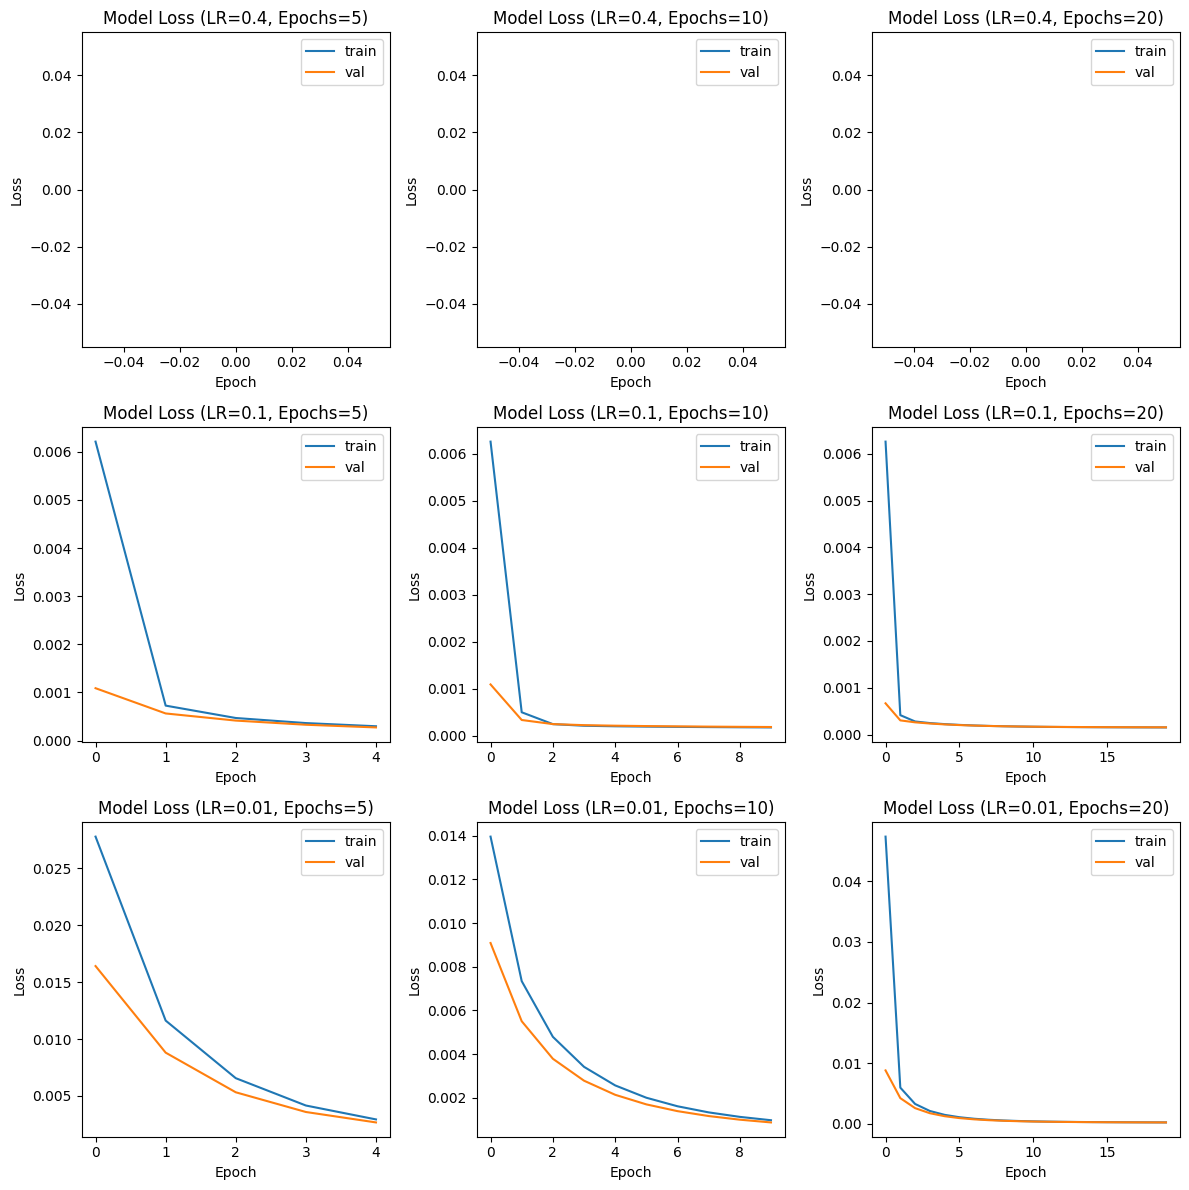

In [15]:
# Lista de tasas de aprendizaje a probar
learning_rates = [0.4,0.1,0.01]

# Lista de números de épocas a probar
epochs_values = [5,10,20]

# Definir la forma de entrada (input_shape)
input_shape = (X_train.shape[1],)

# Función para crear un modelo lineal
def create_linear():
    model = Sequential()
    model.add(Dense(1, input_shape=input_shape, activation='linear'))
    return model

# Configurar el diseño de la figura para todas las gráficas
num_lr = len(learning_rates)
num_epochs = len(epochs_values)

# Crear un grid de subplots
fig, axes = plt.subplots(num_lr, num_epochs, figsize=(12, 12))

# Entrenar diferentes modelos para cada tasa de aprendizaje y número de épocas
for i, lr in enumerate(learning_rates):
    for j, epochs in enumerate(epochs_values):
        # Crear un nuevo modelo
        model_adaline = create_linear()

        # Configurar el modelo y entrenamiento con la tasa de aprendizaje y épocas actuales
        batch_size = 32
        model_adaline.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0), metrics=['mse'])
        start_time = time.time()
        historico = model_adaline.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_validation, y_validation), shuffle=False, validation_freq=1)
        tiempo_total = time.time() - start_time
        print(f"Tiempo de entrenamiento para (lr = {lr}, epoch = {epochs}): {tiempo_total}s \n")
        # Calcular RMSE
        mse = historico.history['val_mse']
        # Agregar la gráfica de la pérdida en el subplot correspondiente
        ax = axes[i, j]
        ax.plot(historico.history['loss'], label='train')
        ax.plot(historico.history['val_loss'], label='val')
        ax.set_title(f'Model Loss (LR={lr}, Epochs={epochs})')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Epoch')
        ax.legend(loc='upper right')

# Ajustar espaciado y mostrar la figura con todas las gráficas
plt.tight_layout()
plt.show()


## 9. Perceptrón multicapa

### 9.2 Perceptrón multicapa con función de activación RELU

Epoch 1/10
804/804 [==============================] - 2s 2ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 6.9018e-04 - val_mse: 6.9018e-04
Epoch 2/10
804/804 [==============================] - 2s 3ms/step - loss: 5.3698e-04 - mse: 5.3698e-04 - val_loss: 4.7441e-04 - val_mse: 4.7441e-04
Epoch 3/10
804/804 [==============================] - 2s 3ms/step - loss: 4.1007e-04 - mse: 4.1007e-04 - val_loss: 4.1457e-04 - val_mse: 4.1457e-04
Epoch 4/10
804/804 [==============================] - 2s 2ms/step - loss: 3.6316e-04 - mse: 3.6316e-04 - val_loss: 3.9169e-04 - val_mse: 3.9169e-04
Epoch 5/10
804/804 [==============================] - 2s 2ms/step - loss: 3.3945e-04 - mse: 3.3945e-04 - val_loss: 3.8064e-04 - val_mse: 3.8064e-04
Epoch 6/10
804/804 [==============================] - 2s 2ms/step - loss: 3.2540e-04 - mse: 3.2540e-04 - val_loss: 3.7353e-04 - val_mse: 3.7353e-04
Epoch 7/10
804/804 [==============================] - 2s 2ms/step - loss: 3.1586e-04 - mse: 3.1586e-04 - val_loss: 3.682

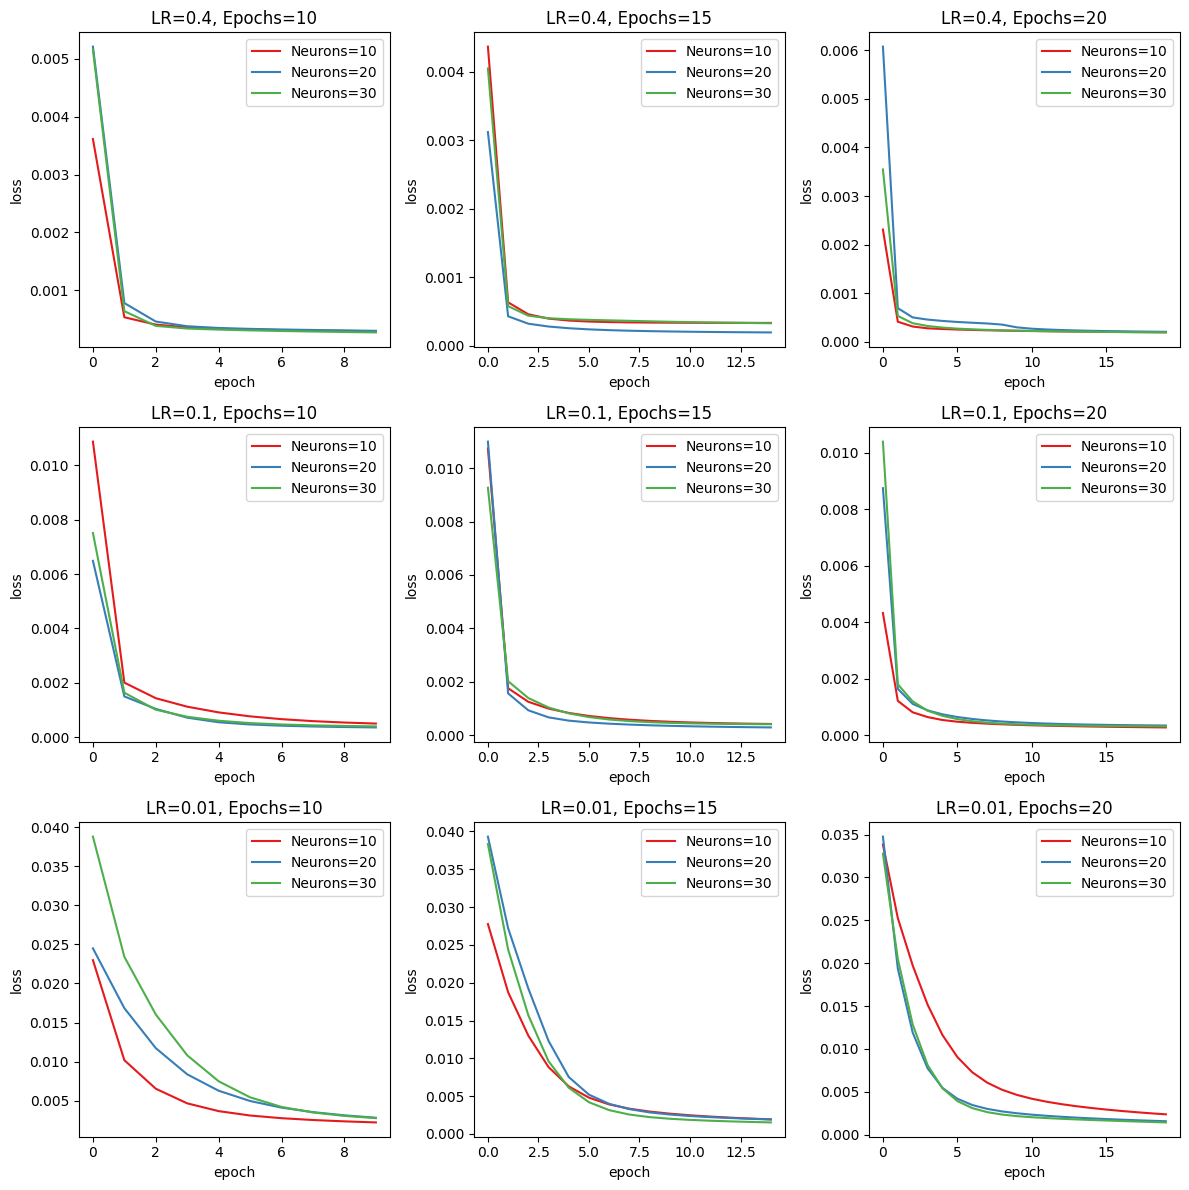

In [16]:
# Definimos la función para crear el modelo
def create_PM_relu(num_hidden_neurons=50):
    #1 capa oculta con relu y 1 neurona de salida con sigmoide
    model = Sequential()
    model.add(Dense(num_hidden_neurons, input_shape=input_shape, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Definimos una lista de valores para learning rates, número de neuronas ocultas y épocas
learning_rates = [0.4,0.1,0.01]
hidden_neurons = [10, 20, 30]
epochs_list = [10, 15, 20]
batch_size = 32

# Configurar el diseño de la figura
fig, axes = plt.subplots(len(learning_rates), len(epochs_list), figsize=(12, 12))

# Iterar sobre las tasas de aprendizaje
for i, lr in enumerate(learning_rates):
    for k, epochs in enumerate(epochs_list):
        # Crear una paleta de colores
        palette = sns.color_palette("Set1", len(hidden_neurons))

        # Configurar la figura para esta tasa de aprendizaje y número de épocas
        ax = axes[i, k]

        for j, num_neurons in enumerate(hidden_neurons):
            model_relu = create_PM_relu(num_neurons)

            # CONFIGURAR MODELO Y ENTRENAMIENTO
            model_relu.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0), metrics=['mse'])
            start_time = time.time()
            historico = model_relu.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_validation, y_validation), shuffle=False, validation_freq=1)
            tiempo_total = time.time() - start_time
            print(f"Tiempo de entrenamiento para (lr = {lr}, epoch = {epochs}): {tiempo_total}s \n")
             # Agregar la gráfica a su subplot correspondiente
            ax.plot(historico.history['loss'], label=f'Neurons={num_neurons}', color=palette[j])
            ax.set_title(f'LR={lr}, Epochs={epochs}')
            ax.set_ylabel('loss')
            ax.set_xlabel('epoch')
            ax.legend()

# Ajustar espaciado y mostrar la figura
plt.tight_layout()
plt.show()


### 9.3 Perceptrón multicapa con función de activación sigmoide

Creamos el modelo

Epoch 1/10
804/804 [==============================] - 2s 2ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 2/10
804/804 [==============================] - 2s 2ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 3/10
804/804 [==============================] - 2s 2ms/step - loss: 9.0794e-04 - mse: 9.0794e-04 - val_loss: 7.8981e-04 - val_mse: 7.8981e-04
Epoch 4/10
804/804 [==============================] - 2s 2ms/step - loss: 7.0361e-04 - mse: 7.0361e-04 - val_loss: 6.4574e-04 - val_mse: 6.4574e-04
Epoch 5/10
804/804 [==============================] - 2s 2ms/step - loss: 5.8492e-04 - mse: 5.8492e-04 - val_loss: 5.5702e-04 - val_mse: 5.5702e-04
Epoch 6/10
804/804 [==============================] - 2s 3ms/step - loss: 5.0943e-04 - mse: 5.0943e-04 - val_loss: 4.9931e-04 - val_mse: 4.9931e-04
Epoch 7/10
804/804 [==============================] - 2s 2ms/step - loss: 4.5946e-04 - mse: 4.5946e-04 - val_loss: 4.6059e-04 - val_mse: 4.6059e

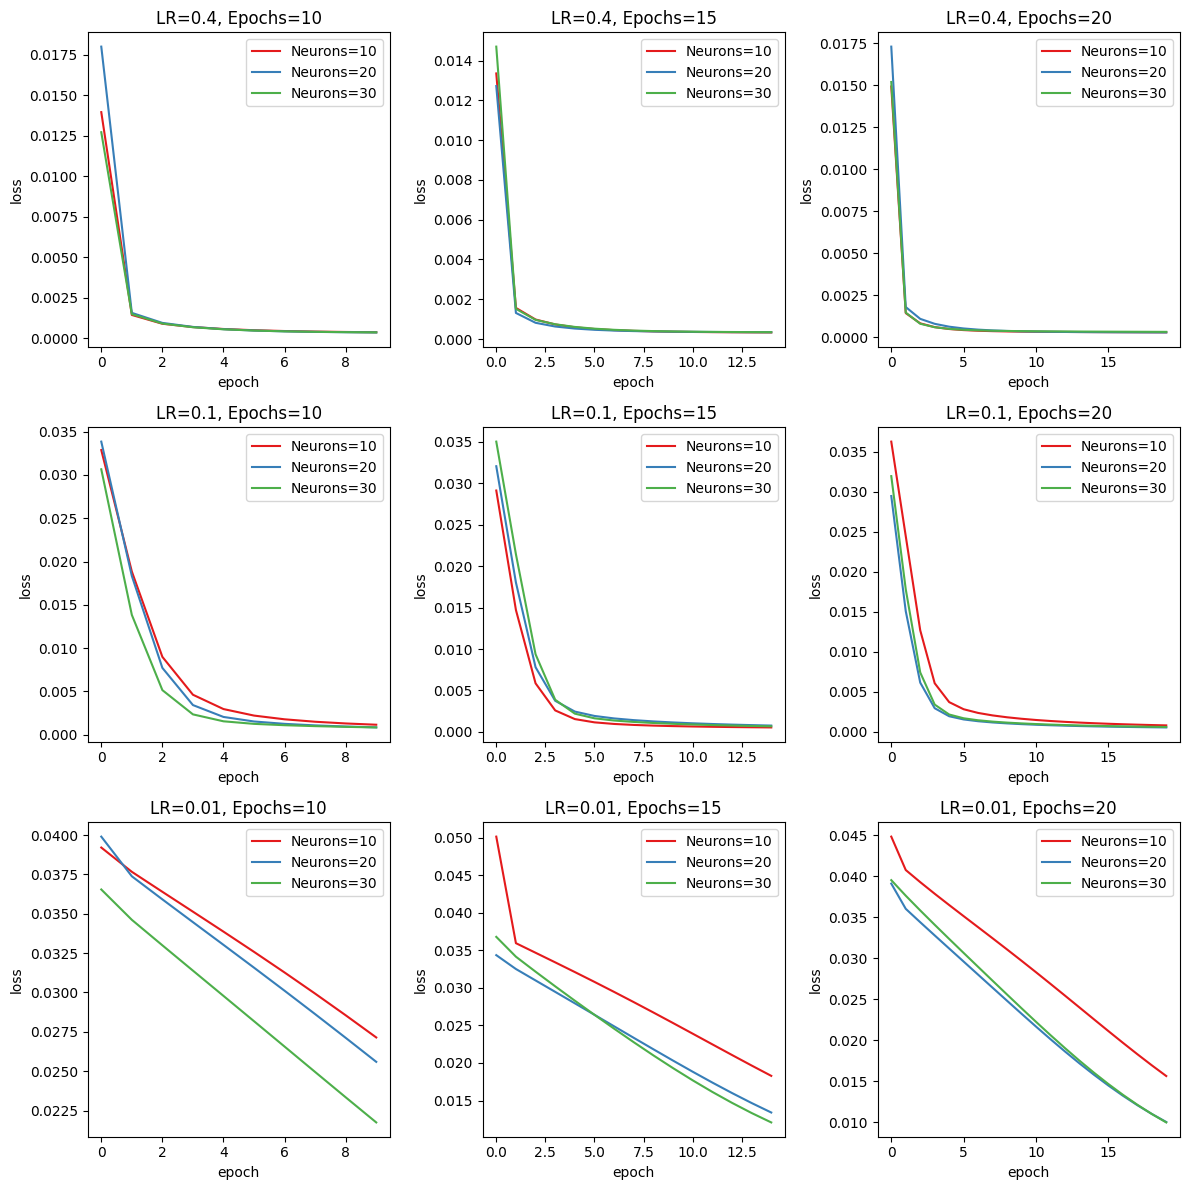

In [17]:
def create_PM_sigmoid(num_hidden_neurons = 50):#se pone un valor por defecto a num_hidden_neurons, pero puede llamarse con otro valor
  #1 capa oculta y 1 neurona de salida con sigmoide
  model = Sequential() # generamos el modelo dandole una forma secuencial:
  model.add(Dense(num_hidden_neurons, input_shape=input_shape, activation='sigmoid')) # capa con x=num_hidden_neurons neuronas activadas con sigmoide
  model.add(Dense(1,activation='sigmoid')) # capa con x=1 neurona (solo una neurona de salida) activada con sigmoide
  return model

# Definir una lista de valores para learning rates, número de neuronas ocultas y épocas
learning_rates = [0.4, 0.1, 0.01]  # Agrega los valores que desees probar
hidden_neurons = [10, 20, 30]  # Agrega los valores que desees probar
epochs_list = [10, 15, 20]  # Agrega los valores que desees probar
batch_size = 32


# Configurar el diseño de la figura
fig, axes = plt.subplots(len(learning_rates), len(epochs_list), figsize=(12, 12))

# Iterar sobre las tasas de aprendizaje
for i, lr in enumerate(learning_rates):
    for k, epochs in enumerate(epochs_list):
        # Crear una paleta de colores
        palette = sns.color_palette("Set1", len(hidden_neurons))

        # Configurar la figura para esta tasa de aprendizaje y número de épocas
        ax = axes[i, k]

        for j, num_neurons in enumerate(hidden_neurons):
            model_sigmoid = create_PM_sigmoid(num_neurons)

            # CONFIGURAR MODELO Y ENTRENAMIENTO
            model_sigmoid.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0), metrics=['mse'])
            start_time = time.time()
            historico = model_sigmoid.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_validation, y_validation), shuffle=False, validation_freq=1)
            tiempo_total = time.time() - start_time
            print(f"Tiempo de entrenamiento para (lr = {lr}, epoch = {epochs}): {tiempo_total}s \n")
            # Agregar la gráfica a su subplot correspondiente
            ax.plot(historico.history['loss'], label=f'Neurons={num_neurons}', color=palette[j])
            ax.set_title(f'LR={lr}, Epochs={epochs}')
            ax.set_ylabel('loss')
            ax.set_xlabel('epoch')
            ax.legend()

# Ajustar espaciado y mostrar la figura
plt.tight_layout()
plt.show()



### 9.4 Elección y guardado del mejor modelo
Observando los resultados, el mejor modelo es el que se construye utilizando la función de activación RELU con un learning_rate de 0.4 y 20 épocas.

In [18]:
mejor_modelo = create_PM_relu(30)
# CONFIGURAR MODELO Y ENTRENAMIENTO
lr = 0.4 # razon de aprendizaje
epochs = 20 # numero de ciclos que se quiere realizar en el entrenamiento
batch_size=32 # ¡¡¡¡¡¡ no cambiar este valor !!!!!!!!!!!!!!
# Para poder ver la curva de validación hay que poner validation_freq=1. Tarda más
mejor_modelo.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0), metrics=['mse'] )
historico = mejor_modelo.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, validation_data=(X_validation,y_validation),
shuffle=False, validation_freq=1)
# Guardamos el modelo completo
mejor_modelo.save('mejor_modelo_PM.keras')

Epoch 1/20
804/804 [==============================] - 2s 2ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 8.1338e-04 - val_mse: 8.1338e-04
Epoch 2/20
804/804 [==============================] - 2s 2ms/step - loss: 5.8910e-04 - mse: 5.8910e-04 - val_loss: 5.1127e-04 - val_mse: 5.1127e-04
Epoch 3/20
804/804 [==============================] - 2s 2ms/step - loss: 4.3935e-04 - mse: 4.3935e-04 - val_loss: 4.6057e-04 - val_mse: 4.6057e-04
Epoch 4/20
804/804 [==============================] - 2s 2ms/step - loss: 3.9149e-04 - mse: 3.9149e-04 - val_loss: 4.3232e-04 - val_mse: 4.3232e-04
Epoch 5/20
804/804 [==============================] - 2s 3ms/step - loss: 3.5744e-04 - mse: 3.5744e-04 - val_loss: 4.0525e-04 - val_mse: 4.0525e-04
Epoch 6/20
804/804 [==============================] - 2s 3ms/step - loss: 3.3230e-04 - mse: 3.3230e-04 - val_loss: 3.8419e-04 - val_mse: 3.8419e-04
Epoch 7/20
804/804 [==============================] - 2s 2ms/step - loss: 3.1719e-04 - mse: 3.1719e-04 - val_loss: 3.707

### 9.6 Error de test y predicciones

In [21]:
# Obtenemos el mejor modelo
mejor_modelo= load_model('mejor_modelo_PM.keras')

# Evaluar el modelo con los datos de prueba
prediccion_test = mejor_modelo.predict(X_test)
mse_test = mean_squared_error(y_test, prediccion_test)

# Imprimir el error de prueba
print(f'Error de test: {mse_test}')

# Calculamos los errores de validación y entrenamiento del historial
historial_entrenamiento = historico.history['loss']
historial_validacion = historico.history['val_loss']

# Guardar los errores de validación y entrenamiento en un archivo CSV
errores_df = pd.DataFrame({'Entrenamiento': historial_entrenamiento, 'Validacion': historial_validacion})
errores_df.to_csv('errores_PM.csv', index=False)

prediccion_test_desnormalizada = prediccion_test * (y_max - y_min) + y_min

y_test_desnormalizada = y_test * (y_max - y_min) + y_min

# Guardar las predicciones y valores deseados en un archivo CSV
predicciones_df = pd.DataFrame({'Predicciones': prediccion_test_desnormalizada.flatten(), 'Valores Deseados': y_test_desnormalizada})
predicciones_df.to_csv('predicciones_y_deseados_PM.csv', index=False)







173/173 [==============================] - 0s 2ms/step
Error de test: 0.0002582004406994434
